# Exploratory notebook : clustering of recipes (executed on Google Colab)

We use standard clustering methods to see if we can find clusters of recipes like pizza, pasta, meat, fish, dessert, etc ...?  
Tests are done on the JOW database.

## Import packages

In [ ]:
import pandas as pd
import numpy as np
import re
import time
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Make figures interactive

In [ ]:
!pip install ipympl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()       # to enable support for third party widgets
#output.disable_custom_widget_manager()    # to disable support

## Google colab settings
Show the gpu infos and change if needed in "Execution" panel.   
Using GPUs is not compulsory here. I moved to Google Colab because my computer is slow.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Mar 20 12:33:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    33W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Import from Google Drive.  
Here the folder 'carbondiet4GD' only contains the folder data/ with subfolders Recipes/ and Tools/ (others are not used).

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/carbondiet4GD.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')     # create a copy directly in colab for efficiency reasons

Mounted at /content/drive


**Indicate the path where the folder data/ is located.**

In [ ]:
#data_path = '../'
data_path = 'carbondiet4GD/'

## Import and prepare the JOW database

In [ ]:
jow_data = pd.read_json(data_path + 'data/Recipes/recipes_jow.json')
jow_data = jow_data.transpose()
pd.set_option('display.max_colwidth', None)
jow_data['recipe_name'] = jow_data.index
jow_data.head()

,cuisson,ingredients,recipe_name
Yakitori bœuf fromage,10 minutes,"[[80 g, Bœuf (carpaccio)], [100 g, Emmental], [1 càs, Sauce Teriyaki], [70 g, Riz], [6, Pics à brochette]]",Yakitori bœuf fromage
Gnocchis Epinards Gorgonzola,5 minutes,"[[150 g, Gnocchi], [100 g, Epinard (frais)], [30 g, Gorgonzola], [5 cl, Crème liquide]]",Gnocchis Epinards Gorgonzola
Dahl de lentilles corail,plat froid,"[[50 g, Lentilles corail], [80 g, Tomate (chair)], [5 cl, Lait de coco], [1/2 gou., Ail]]",Dahl de lentilles corail
Veggie lasagna,50 minutes,"[[50 g, Lasagnes (cru)], [150 g, Courgette], [150 g, Tomate (purée)], [80 g, Champignons de Paris (frais)], [1/2, Mozzarella (boule)]]",Veggie lasagna
Pasta alla carbonara,9 minutes,"[[100 g, Pâtes (spaghetti)], [3 tran., Pancetta], [1, Œuf], [40 g, Parmesan (morceaux)]]",Pasta alla carbonara


We remove ligatures, e.g. Bœuf -> Boeuf.  
This is probably useless.

In [ ]:
REGEX_REPLACEMENTS = [(r"\u0153", "oe"), \
                      (r"\u0152", "Oe")]

def remove_ligatures(transcript):
    for old, new in REGEX_REPLACEMENTS:
        transcript = re.sub(old, new, transcript, flags=re.IGNORECASE)
    return transcript

#jow_data['recipe_name'] = jow_data['recipe_name'].apply(lambda s: remove_ligatures(str(s)))
jow_data = jow_data.rename({'ingredients': 'ingredients_with_quantity'}, axis = 1)
jow_data.head()

,cuisson,ingredients_with_quantity,recipe_name
Yakitori bœuf fromage,10 minutes,"[[80 g, Bœuf (carpaccio)], [100 g, Emmental], [1 càs, Sauce Teriyaki], [70 g, Riz], [6, Pics à brochette]]",Yakitori bœuf fromage
Gnocchis Epinards Gorgonzola,5 minutes,"[[150 g, Gnocchi], [100 g, Epinard (frais)], [30 g, Gorgonzola], [5 cl, Crème liquide]]",Gnocchis Epinards Gorgonzola
Dahl de lentilles corail,plat froid,"[[50 g, Lentilles corail], [80 g, Tomate (chair)], [5 cl, Lait de coco], [1/2 gou., Ail]]",Dahl de lentilles corail
Veggie lasagna,50 minutes,"[[50 g, Lasagnes (cru)], [150 g, Courgette], [150 g, Tomate (purée)], [80 g, Champignons de Paris (frais)], [1/2, Mozzarella (boule)]]",Veggie lasagna
Pasta alla carbonara,9 minutes,"[[100 g, Pâtes (spaghetti)], [3 tran., Pancetta], [1, Œuf], [40 g, Parmesan (morceaux)]]",Pasta alla carbonara


Let's add a column for ingredients only (no quantity, informations in parenthesis are removed)

In [ ]:
# Known from previous notebook '[Genevieve] ingredients_scores__process.ipynb'
meaningless_jow_ingredients = ['1/10 bou.', '1/5 bou.', '1/50 bou.', '6 pinc.', '1 càc', '1/4', '3 pinc.', '2 càs', \
                               '1 cm', '1/20 bou.', '1 càs', '1/2 càc', 'Papier cuisson', 'Pics à brochette']

def extract_ingredients(row):
    ingredients = []
    for x in row:
        if len(x)>1:         
            ingredient = x[-1]    # the ingredient is the last element of the list 'row'  
            if ingredient not in meaningless_jow_ingredients:   # keep only meaningfull ingredients
                ingredient = remove_ligatures(ingredient)
                ingredients.append(ingredient) 

    ingredients = [re.sub("[\(\[].*?[\)\]]", "", ingredient) for ingredient in ingredients]  #remove informations in parenthesis
    # remove blank at the end of the string that remained when parenthesis have been removed
    ingredients = [ing[:-1] if ing[-1]==" " else ing for ing in ingredients]   

    return ingredients

jow_data['ingredients'] = jow_data['ingredients_with_quantity'].apply(extract_ingredients)
jow_data.head()

,cuisson,ingredients_with_quantity,recipe_name,ingredients
Yakitori bœuf fromage,10 minutes,"[[80 g, Bœuf (carpaccio)], [100 g, Emmental], [1 càs, Sauce Teriyaki], [70 g, Riz], [6, Pics à brochette]]",Yakitori bœuf fromage,"[Boeuf, Emmental, Sauce Teriyaki, Riz]"
Gnocchis Epinards Gorgonzola,5 minutes,"[[150 g, Gnocchi], [100 g, Epinard (frais)], [30 g, Gorgonzola], [5 cl, Crème liquide]]",Gnocchis Epinards Gorgonzola,"[Gnocchi, Epinard, Gorgonzola, Crème liquide]"
Dahl de lentilles corail,plat froid,"[[50 g, Lentilles corail], [80 g, Tomate (chair)], [5 cl, Lait de coco], [1/2 gou., Ail]]",Dahl de lentilles corail,"[Lentilles corail, Tomate, Lait de coco, Ail]"
Veggie lasagna,50 minutes,"[[50 g, Lasagnes (cru)], [150 g, Courgette], [150 g, Tomate (purée)], [80 g, Champignons de Paris (frais)], [1/2, Mozzarella (boule)]]",Veggie lasagna,"[Lasagnes, Courgette, Tomate, Champignons de Paris, Mozzarella]"
Pasta alla carbonara,9 minutes,"[[100 g, Pâtes (spaghetti)], [3 tran., Pancetta], [1, Œuf], [40 g, Parmesan (morceaux)]]",Pasta alla carbonara,"[Pâtes, Pancetta, oeuf, Parmesan]"


Add the column 'name_with_ingredients' by concatenating recipe names and ingredients

In [ ]:
jow_data['name_with_ingredients'] = jow_data.apply(lambda row: row['recipe_name'] + ", " + ', '.join(row['ingredients']), axis = 1)
jow_data.head(2)

,cuisson,ingredients_with_quantity,recipe_name,ingredients,name_with_ingredients
Yakitori bœuf fromage,10 minutes,"[[80 g, Bœuf (carpaccio)], [100 g, Emmental], [1 càs, Sauce Teriyaki], [70 g, Riz], [6, Pics à brochette]]",Yakitori bœuf fromage,"[Boeuf, Emmental, Sauce Teriyaki, Riz]","Yakitori bœuf fromage, Boeuf, Emmental, Sauce Teriyaki, Riz"
Gnocchis Epinards Gorgonzola,5 minutes,"[[150 g, Gnocchi], [100 g, Epinard (frais)], [30 g, Gorgonzola], [5 cl, Crème liquide]]",Gnocchis Epinards Gorgonzola,"[Gnocchi, Epinard, Gorgonzola, Crème liquide]","Gnocchis Epinards Gorgonzola, Gnocchi, Epinard, Gorgonzola, Crème liquide"


## Import and prepare the menu database (to test the clustering approach afterwards)


In [ ]:
menu_data = pd.read_json(data_path+'data/Tools/MenuTo7tJOWRecipes_v1.json')
menu_data.head(10)

,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Closest 7t recipe by hand
0,burgart_205074_c70.jpg,Burgers,Superfin,"Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart","[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
1,burgart_205074_c70.jpg,Burgers,Bon & Beau,"Bœuf (VBF Metzger), Cheddar, Sucrine, Bacon, Tomate Confite, Sauce poivre maison","[Super Bacon Burger, Summer burger]",no match
3,burgart_205074_c70.jpg,Burgers,Green Chicken,"Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",no match,"[awesome turkey burgers, blue cheese stuffed turkey burgers, chicken & broccoli burgers, greek burgers, spinach feta turkey burgers]"
4,burgart_205074_c70.jpg,Poke Bowls,Black bowl,"Thon, Riz noir, Avocat, Oignon rouge, Cébette, Concombre, Sésame, Coriandre, Grenade, Sauce douce","[Tuna bowl, Primavera Poke bowl]",no match
5,burgart_205074_c70.jpg,Salades,Crispy Caesar,"Croquettes de poulet, Parmesan, Champignons bruns, Salade Romaine, Ciboulette","[Salade César, Salade au poulet pané]","[better-for-you grilled chicken caesar salad, favorite grilled chicken caesar salad, grilled chicken a la caesar, grilled chicken caesar salad]"
6,burgart_205074_c70.jpg,Desserts,Cheesecake maison,None,Cheesecake,no match
7,burgart_205074_c70.jpg,Desserts,Mousse au chocolat maison,None,Mousse au chocolat maison,"[chocolate mousse, chocolate dream mousse, raw chocolate mousse, lactose free]"
8,burgart_205074_c70.jpg,Desserts,Fondant au chocolat artisan boulanger,None,Fondant au chocolat,no match
9,burgart_205074_c70.jpg,Desserts,Financier artisan boulanger,None,"[Financier cerises noires & pistache, Financier à la framboise]",no match
17,Carte-in-seoul.png,Anju,Mandoo (6 pcs),Raviolis maison grillés au porc et légumes,no match,no match


Prepare the list of queries for test, first by concatenating the title and subtitle of menu recipes 

In [ ]:
menu_data['Menu Title and Subtitle'] = menu_data.apply(lambda row: row['Menu Title'] + ", " + row['Menu Subtitle'], axis = 1)
menu_data.head()

,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Closest 7t recipe by hand,Menu Title and Subtitle
0,burgart_205074_c70.jpg,Burgers,Superfin,"Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart","[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match,"Burgers, Superfin"
1,burgart_205074_c70.jpg,Burgers,Bon & Beau,"Bœuf (VBF Metzger), Cheddar, Sucrine, Bacon, Tomate Confite, Sauce poivre maison","[Super Bacon Burger, Summer burger]",no match,"Burgers, Bon & Beau"
3,burgart_205074_c70.jpg,Burgers,Green Chicken,"Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",no match,"[awesome turkey burgers, blue cheese stuffed turkey burgers, chicken & broccoli burgers, greek burgers, spinach feta turkey burgers]","Burgers, Green Chicken"
4,burgart_205074_c70.jpg,Poke Bowls,Black bowl,"Thon, Riz noir, Avocat, Oignon rouge, Cébette, Concombre, Sésame, Coriandre, Grenade, Sauce douce","[Tuna bowl, Primavera Poke bowl]",no match,"Poke Bowls, Black bowl"
5,burgart_205074_c70.jpg,Salades,Crispy Caesar,"Croquettes de poulet, Parmesan, Champignons bruns, Salade Romaine, Ciboulette","[Salade César, Salade au poulet pané]","[better-for-you grilled chicken caesar salad, favorite grilled chicken caesar salad, grilled chicken a la caesar, grilled chicken caesar salad]","Salades, Crispy Caesar"


Replace NaN in the ingredients column by empty string

In [ ]:
menu_data = menu_data.fillna("")
menu_data.head()

,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Closest 7t recipe by hand,Menu Title and Subtitle
0,burgart_205074_c70.jpg,Burgers,Superfin,"Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart","[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match,"Burgers, Superfin"
1,burgart_205074_c70.jpg,Burgers,Bon & Beau,"Bœuf (VBF Metzger), Cheddar, Sucrine, Bacon, Tomate Confite, Sauce poivre maison","[Super Bacon Burger, Summer burger]",no match,"Burgers, Bon & Beau"
3,burgart_205074_c70.jpg,Burgers,Green Chicken,"Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",no match,"[awesome turkey burgers, blue cheese stuffed turkey burgers, chicken & broccoli burgers, greek burgers, spinach feta turkey burgers]","Burgers, Green Chicken"
4,burgart_205074_c70.jpg,Poke Bowls,Black bowl,"Thon, Riz noir, Avocat, Oignon rouge, Cébette, Concombre, Sésame, Coriandre, Grenade, Sauce douce","[Tuna bowl, Primavera Poke bowl]",no match,"Poke Bowls, Black bowl"
5,burgart_205074_c70.jpg,Salades,Crispy Caesar,"Croquettes de poulet, Parmesan, Champignons bruns, Salade Romaine, Ciboulette","[Salade César, Salade au poulet pané]","[better-for-you grilled chicken caesar salad, favorite grilled chicken caesar salad, grilled chicken a la caesar, grilled chicken caesar salad]","Salades, Crispy Caesar"


Do the same by concatenating the title, subtitle and ingredients of menu recipes

In [ ]:
def add_ingredients(row):
    if row['Menu Ingredients']=='':
        res = row['Menu Title'] + ", " + row['Menu Subtitle']
    else:
        res = row['Menu Title'] + ", " + row['Menu Subtitle'] + ", " + row['Menu Ingredients']
    return res

menu_data['Menu all'] = menu_data.apply(add_ingredients, axis = 1)
menu_data.head(8)

,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Closest 7t recipe by hand,Menu Title and Subtitle,Menu all
0,burgart_205074_c70.jpg,Burgers,Superfin,"Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart","[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match,"Burgers, Superfin","Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart"
1,burgart_205074_c70.jpg,Burgers,Bon & Beau,"Bœuf (VBF Metzger), Cheddar, Sucrine, Bacon, Tomate Confite, Sauce poivre maison","[Super Bacon Burger, Summer burger]",no match,"Burgers, Bon & Beau","Burgers, Bon & Beau, Bœuf (VBF Metzger), Cheddar, Sucrine, Bacon, Tomate Confite, Sauce poivre maison"
3,burgart_205074_c70.jpg,Burgers,Green Chicken,"Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",no match,"[awesome turkey burgers, blue cheese stuffed turkey burgers, chicken & broccoli burgers, greek burgers, spinach feta turkey burgers]","Burgers, Green Chicken","Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison"
4,burgart_205074_c70.jpg,Poke Bowls,Black bowl,"Thon, Riz noir, Avocat, Oignon rouge, Cébette, Concombre, Sésame, Coriandre, Grenade, Sauce douce","[Tuna bowl, Primavera Poke bowl]",no match,"Poke Bowls, Black bowl","Poke Bowls, Black bowl, Thon, Riz noir, Avocat, Oignon rouge, Cébette, Concombre, Sésame, Coriandre, Grenade, Sauce douce"
5,burgart_205074_c70.jpg,Salades,Crispy Caesar,"Croquettes de poulet, Parmesan, Champignons bruns, Salade Romaine, Ciboulette","[Salade César, Salade au poulet pané]","[better-for-you grilled chicken caesar salad, favorite grilled chicken caesar salad, grilled chicken a la caesar, grilled chicken caesar salad]","Salades, Crispy Caesar","Salades, Crispy Caesar, Croquettes de poulet, Parmesan, Champignons bruns, Salade Romaine, Ciboulette"
6,burgart_205074_c70.jpg,Desserts,Cheesecake maison,,Cheesecake,no match,"Desserts, Cheesecake maison","Desserts, Cheesecake maison"
7,burgart_205074_c70.jpg,Desserts,Mousse au chocolat maison,,Mousse au chocolat maison,"[chocolate mousse, chocolate dream mousse, raw chocolate mousse, lactose free]","Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison"
8,burgart_205074_c70.jpg,Desserts,Fondant au chocolat artisan boulanger,,Fondant au chocolat,no match,"Desserts, Fondant au chocolat artisan boulanger","Desserts, Fondant au chocolat artisan boulanger"


## Embedding of JOW recipes

In [ ]:
! pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sentence_transformers import SentenceTransformer, util
model =  SentenceTransformer("dangvantuan/sentence-camembert-large")

We compute the embeddings of JOW recipes labeled with 'recipe_name' and the embeddings of JOW recipes labeled with 'name_with_ingredients'.

In [ ]:
t0 = time.time()
jow_title_recipes = list(jow_data['recipe_name'].values)
jow_title_embeddings = model.encode(jow_title_recipes, convert_to_tensor=False)
print("Time lapse for JOW embedding (s) = ", time.time()-t0)

t0 = time.time()
jow_fullname_recipes = list(jow_data['name_with_ingredients'].values)
jow_fullname_embeddings = model.encode(jow_fullname_recipes, convert_to_tensor=False)
print("Time lapse for JOW embedding (s) = ", time.time()-t0)

Time lapse for JOW embedding (s) =  9.397165060043335
Time lapse for JOW embedding (s) =  11.150742530822754


In [ ]:
print(jow_title_embeddings.shape)
print(jow_fullname_embeddings.shape)

(1406, 1024)
(1406, 1024)


Each of the 1406 Jow recipes is embedded into a vector of size 1024.

Add feature scaling (before running KMeans, otherwise the clusters may be stretched and KMeans will perform poorly)


In [ ]:
jow_title_embeddings.std(axis = 0)

array([0.3108665 , 0.25831476, 0.22427617, ..., 0.24456432, 0.30962086,
       0.23546255], dtype=float32)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler1 = StandardScaler()
scaler2 = StandardScaler()
jow_title_embeddings_scaled = scaler1.fit_transform(jow_title_embeddings)
jow_fullname_embeddings_scaled = scaler2.fit_transform(jow_fullname_embeddings)

In [ ]:
jow_title_embeddings_scaled.std(axis = 0)

array([0.99999964, 1.0000004 , 0.9999999 , ..., 0.9999995 , 1.0000002 ,
       0.9999999 ], dtype=float32)

## Clustering with K-Means on JOW embedding vectors


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

KMeans is fast but the drawback of the algorithm is that it requires 'n_clusters' (number of clusters) as an input parameter. Let's try to find a good choice for the number of cluster

In [ ]:
from tqdm import tqdm

inertia_list = []
silhouette_score_list = []

for k in tqdm(np.arange(2, 100)):    # loop on the number of clusters k
    kmeans = KMeans(n_clusters = k, n_init = 10)                # define the model
    kmeans.fit(jow_title_embeddings_scaled)        # compute the clusters    
    inertia = kmeans.inertia_
    silhouette = silhouette_score(jow_title_embeddings_scaled, kmeans.labels_)
    inertia_list.append(inertia)
    silhouette_score_list.append(silhouette)

100%|██████████| 98/98 [07:59<00:00,  4.89s/it]


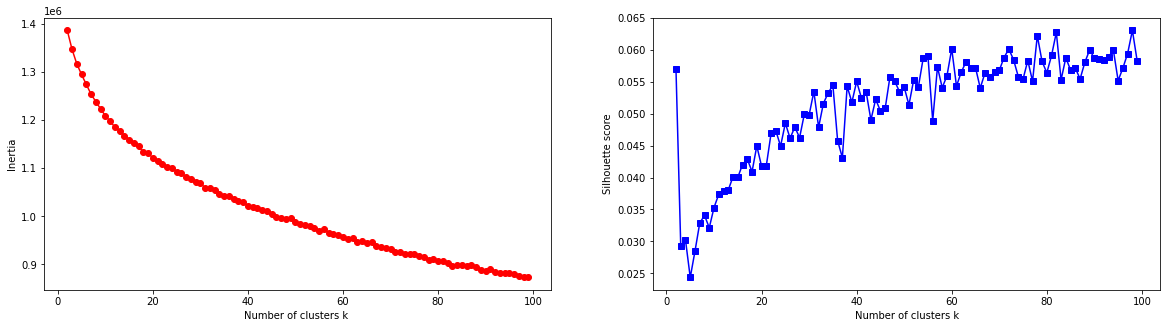

In [ ]:
fig = plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.plot(np.arange(2, 100), inertia_list, '-ro')
plt.xlabel("Number of clusters k ")
plt.ylabel("Inertia")
plt.subplot(122)
plt.plot(np.arange(2, 100), silhouette_score_list, '-bs')
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette score");

The "elbow method" on the (left) inertia curves tells us that the optimal $k\approx 10$ (location of the inflexion point).  
But the (right) silhouette score tells roughly the opposite. Remember that (see A. Géron's book), "The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster." Here it seems that we should take $k\gtrsim 40$ but even for such values, the silhouette score is very low compared to 1 and so **we don't expect good clustering -> this is not really surprising since the space dimension is huge (1024).**

Fix $k$, compute the clusters with KMeans and build a dataframe with the results (ie each recipe with its cluster label)

In [ ]:
k = 20     # Choose the number of clusters
kmeans20 = KMeans(n_clusters = k, n_init = 10, random_state = 123)                # define the model
kmeans20.fit(jow_title_embeddings_scaled)        # compute the clusters    

dict_res_kmeans = {}
dict_res_kmeans['recipe_name'] = list(jow_data['recipe_name'].values)
dict_res_kmeans['cluster_number'] = kmeans20.labels_

df_res_kmeans_k20 = pd.DataFrame.from_dict(dict_res_kmeans)

In [ ]:
df_res_kmeans_k20.sort_values(by = 'cluster_number')

,recipe_name,cluster_number
156,Salade hivernale,0
699,Salade de lentilles aux figues,0
698,"Salade de blé, avocat & grenade",0
695,Salade de coquillettes méditerranéenne,0
1259,"Salade betterave, bleu & noix",0
...,...,...
370,Saucisse purée & épinards,19
840,"Nuggets veggie, purée & haricots verts",19
621,"Salade nectarines, haricots & amandes",19
261,Saumon & haricots rôtis,19


**Ohoh the clustering is really better than expected and we can clearly identify the 'logic' behind the clusters (even if of course there are some mis-classified recipes in each cluster but not so many):**
- 0 <-> salad, fresh starters
- 1 <-> recipes with 'courgette'
- 2 <-> various veggie meals (with 'chèvre' and/or 'oeuf' and/or 'poireaux', etc ...)
- 3 <-> various recipes with fish (mainly 'saumon, 'thon')
- 4 <-> various desserts (some errors due to confusion between 'tarte salée' and 'tarte sucrée'
- 5 <-> various meals, rather veggie, many with 'brocolis' or 'choux'
- 6 <-> various meals, mainly with 'curry' and keyworks "rôti" or 'sauté' etc ...
- ...
- 17 <-> various meals with 'purée' and/or 'patate' and/or 'pomme de terre' and/or 'pomme' but also some others with no clear origins
- 18 <-> pasta, pizza, meals with italian-related keywords (some errors with the word 'pasta' e.g. 'avocado pasta'
- 19 <-> various recipes with the ingredient 'cabillaud'  

Note the order may be changed since random_state in kmeans was not defined in the previous version





Let's see what we get with only 10 clusters

In [ ]:
k = 10     # Choose the number of clusters
kmeans10 = KMeans(n_clusters = k, n_init = 10, random_state = 123)                # define the model
kmeans10.fit(jow_title_embeddings_scaled)        # compute the clusters    

dict_res_kmeans = {}
dict_res_kmeans['recipe_name'] = list(jow_data['recipe_name'].values)
dict_res_kmeans['cluster_number'] = kmeans10.labels_

df_res_kmeans_k10 = pd.DataFrame.from_dict(dict_res_kmeans)

In [ ]:
df_res_kmeans_k10.sort_values(by = 'cluster_number')

,recipe_name,cluster_number
1235,"Salade endives, avocat & comté",0
763,Polenta & ragu,0
1232,Galette de sarrasin,0
774,Salade de ravioli ricotta et épinards,0
776,Salade fraîche aux petits pois,0
...,...,...
824,Cabillaud & carottes au beurre blanc,9
694,Crevettes au curry express,9
829,"Nuggets, riz & brocolis",9
746,Velouté coco chou-fleur,9


0 <-> salads, starters  
1 <-> various meals with meat (mainly with 'boeuf', 'veau', 'porc', 'jambon', 'saucisse')   
2 <-> various meals with 'tomate'  
3 <-> pasta, pizza, 'tarte salée', gnocchis, meals with italian-related keywords  
4 <-> various meals with 'patate' or 'pomme de terre' or 'purée' but also 'courgette' ... not so clear  
5 <-> aperitifs, starters  
6 <-> various meals with 'saumon' mainly, also 'thon' etc ...   
7 <-> various meals with 'poulet' or 'canard'  
8 <-> desserts    
9 <-> various meals, mainly with 'cabillaud' or 'crevette' but also others  
 

 



Add the meaning of clusters in the dataframe 

In [ ]:
df_res_kmeans_k10['cluster_meaning'] = list(df_res_kmeans_k10['cluster_number'].values)

cluster_numbers = [i for i in range(10)]
cluster_meanings = ["salads, starters", \
                    "meals with meat (beek, pork)", \
                    "meals with tomato", \
                    "pasta, pizza, etc", \
                    "meals with 'patate', 'courgette', etc", \
                    'aperitifs, starters', \
                    "meals with 'saumon', 'thon'", \
                    "meals with chicken, duck", \
                    "desserts", \
                    "meals with 'cabillaud' or 'crevette' etc"]

df_res_kmeans_k10['cluster_meaning'] = df_res_kmeans_k10['cluster_meaning'].replace(cluster_numbers, cluster_meanings)  
df_res_kmeans_k10.head(10)

,recipe_name,cluster_number,cluster_meaning
0,Yakitori bœuf fromage,1,"meals with meat (beek, pork)"
1,Gnocchis Epinards Gorgonzola,3,"pasta, pizza, etc"
2,Dahl de lentilles corail,5,"aperitifs, starters"
3,Veggie lasagna,1,"meals with meat (beek, pork)"
4,Pasta alla carbonara,3,"pasta, pizza, etc"
5,Tarte spirale de légumes,4,"meals with 'patate', 'courgette', etc"
6,Flammeküeche,5,"aperitifs, starters"
7,Chili con carne,1,"meals with meat (beek, pork)"
8,Les classiques coquillettes au jambon,1,"meals with meat (beek, pork)"
9,Knack & purée,4,"meals with 'patate', 'courgette', etc"


## Test of KMeans clustering on menu recipes

First compute the embeddings and scale them

In [ ]:
menu_title_recipes = list(menu_data['Menu Title and Subtitle'].values)
menu_title_embeddings = model.encode(menu_title_recipes, convert_to_tensor=False)
menu_title_embeddings_scaled = scaler1.transform(menu_title_embeddings)

Assign the menu recipes to their closest clusters

In [ ]:
menu_clusters10 = kmeans10.predict(menu_title_embeddings_scaled)        # compute the clusters    

dict_res_menu_kmeans = {}
dict_res_menu_kmeans['Menu Title and Subtitle'] = list(menu_data['Menu Title and Subtitle'].values)
dict_res_menu_kmeans['cluster_number'] = menu_clusters10

df_res_menu_kmeans_k10 = pd.DataFrame.from_dict(dict_res_menu_kmeans)

In [ ]:
df_res_menu_kmeans_k10['cluster_meaning'] = list(df_res_menu_kmeans_k10['cluster_number'].values)
df_res_menu_kmeans_k10['cluster_meaning'] = df_res_menu_kmeans_k10['cluster_meaning'].replace(cluster_numbers, cluster_meanings)  
df_res_menu_kmeans_k10

,Menu Title and Subtitle,cluster_number,cluster_meaning
0,"Burgers, Superfin",1,"meals with meat (beek, pork)"
1,"Burgers, Bon & Beau",1,"meals with meat (beek, pork)"
2,"Burgers, Green Chicken",1,"meals with meat (beek, pork)"
3,"Poke Bowls, Black bowl",5,"aperitifs, starters"
4,"Salades, Crispy Caesar",0,"salads, starters"
5,"Desserts, Cheesecake maison",8,desserts
6,"Desserts, Mousse au chocolat maison",8,desserts
7,"Desserts, Fondant au chocolat artisan boulanger",8,desserts
8,"Desserts, Financier artisan boulanger",8,desserts
9,"Anju, Mandoo (6 pcs)",5,"aperitifs, starters"


Not so bad. Is it better if we can give the full name of menu recipes?

In [ ]:
menu_fullname_recipes = list(menu_data['Menu all'].values)
menu_fullname_embeddings = model.encode(menu_fullname_recipes, convert_to_tensor=False)
menu_fullname_embeddings_scaled = scaler1.transform(menu_fullname_embeddings)

In [ ]:
menu_clusters10 = kmeans10.predict(menu_fullname_embeddings_scaled)        # compute the clusters    

dict_res_menu_kmeans = {}
dict_res_menu_kmeans['Menu Title and Subtitle'] = list(menu_data['Menu Title and Subtitle'].values)
dict_res_menu_kmeans['Menu all'] = list(menu_data['Menu all'].values)
dict_res_menu_kmeans['cluster_number'] = menu_clusters10

df_res_menu_kmeans_k10 = pd.DataFrame.from_dict(dict_res_menu_kmeans)

In [ ]:
df_res_menu_kmeans_k10['cluster_meaning'] = list(df_res_menu_kmeans_k10['cluster_number'].values)
df_res_menu_kmeans_k10['cluster_meaning'] = df_res_menu_kmeans_k10['cluster_meaning'].replace(cluster_numbers, cluster_meanings)  
df_res_menu_kmeans_k10

,Menu Title and Subtitle,Menu all,cluster_number,cluster_meaning
0,"Burgers, Superfin","Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",1,"meals with meat (beek, pork)"
1,"Burgers, Bon & Beau","Burgers, Bon & Beau, Bœuf (VBF Metzger), Cheddar, Sucrine, Bacon, Tomate Confite, Sauce poivre maison",1,"meals with meat (beek, pork)"
2,"Burgers, Green Chicken","Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",1,"meals with meat (beek, pork)"
3,"Poke Bowls, Black bowl","Poke Bowls, Black bowl, Thon, Riz noir, Avocat, Oignon rouge, Cébette, Concombre, Sésame, Coriandre, Grenade, Sauce douce",6,"meals with 'saumon', 'thon'"
4,"Salades, Crispy Caesar","Salades, Crispy Caesar, Croquettes de poulet, Parmesan, Champignons bruns, Salade Romaine, Ciboulette",3,"pasta, pizza, etc"
5,"Desserts, Cheesecake maison","Desserts, Cheesecake maison",8,desserts
6,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",8,desserts
7,"Desserts, Fondant au chocolat artisan boulanger","Desserts, Fondant au chocolat artisan boulanger",8,desserts
8,"Desserts, Financier artisan boulanger","Desserts, Financier artisan boulanger",8,desserts
9,"Anju, Mandoo (6 pcs)","Anju, Mandoo (6 pcs), Raviolis maison grillés au porc et légumes",1,"meals with meat (beek, pork)"


-> better for menu recipes whose titles are unclear (e.g. korean ones), less good for others (e.g. pasta with tomatoes) are now classified in the cluster "meals with tomato" instead of "pasta".

## Other clustering method : Hierarchical clustering on JOW embeddings

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score

How many clusters should we take?  
Note it is not compulsory to give `n_clusters` as an input parameter, `distance_threshold` can be used instead.

In [ ]:
calinski_score_list = []
silhouette_score_list = []

for k in tqdm(np.arange(2, 100)):    # loop on the number of clusters k
    cah = AgglomerativeClustering(n_clusters = k)                # define the model
    cah.fit(jow_title_embeddings_scaled)        # compute the clusters    
    calinski = calinski_harabasz_score(jow_title_embeddings_scaled, cah.labels_)
    silhouette = silhouette_score(jow_title_embeddings_scaled, cah.labels_)
    calinski_score_list.append(calinski)
    silhouette_score_list.append(silhouette)

100%|██████████| 98/98 [01:32<00:00,  1.06it/s]


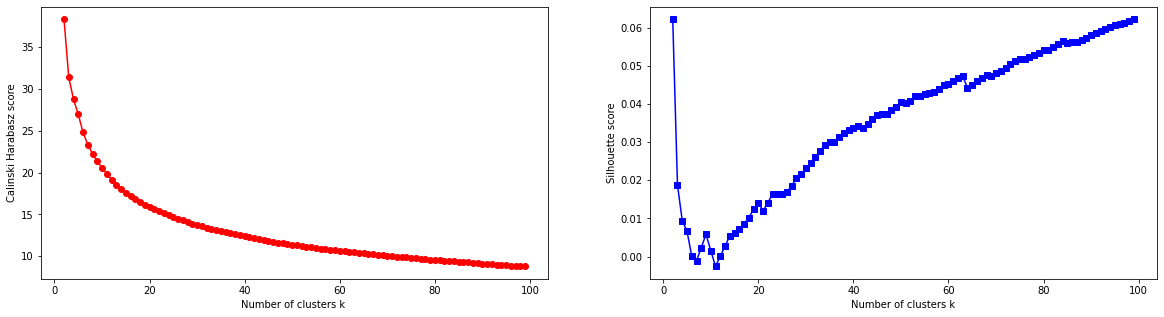

In [ ]:
fig = plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.plot(np.arange(2, 100), calinski_score_list, '-ro')
plt.xlabel("Number of clusters k ")
plt.ylabel("Calinski Harabasz score")
plt.subplot(122)
plt.plot(np.arange(2, 100), silhouette_score_list, '-bs')
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette score");

CH score must be maximized : clearly the figure suggests that adding clusters is bad, probably it is a signature of bad clustering results ... don't really know how to interpret.

### Plot the dendrogram 

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

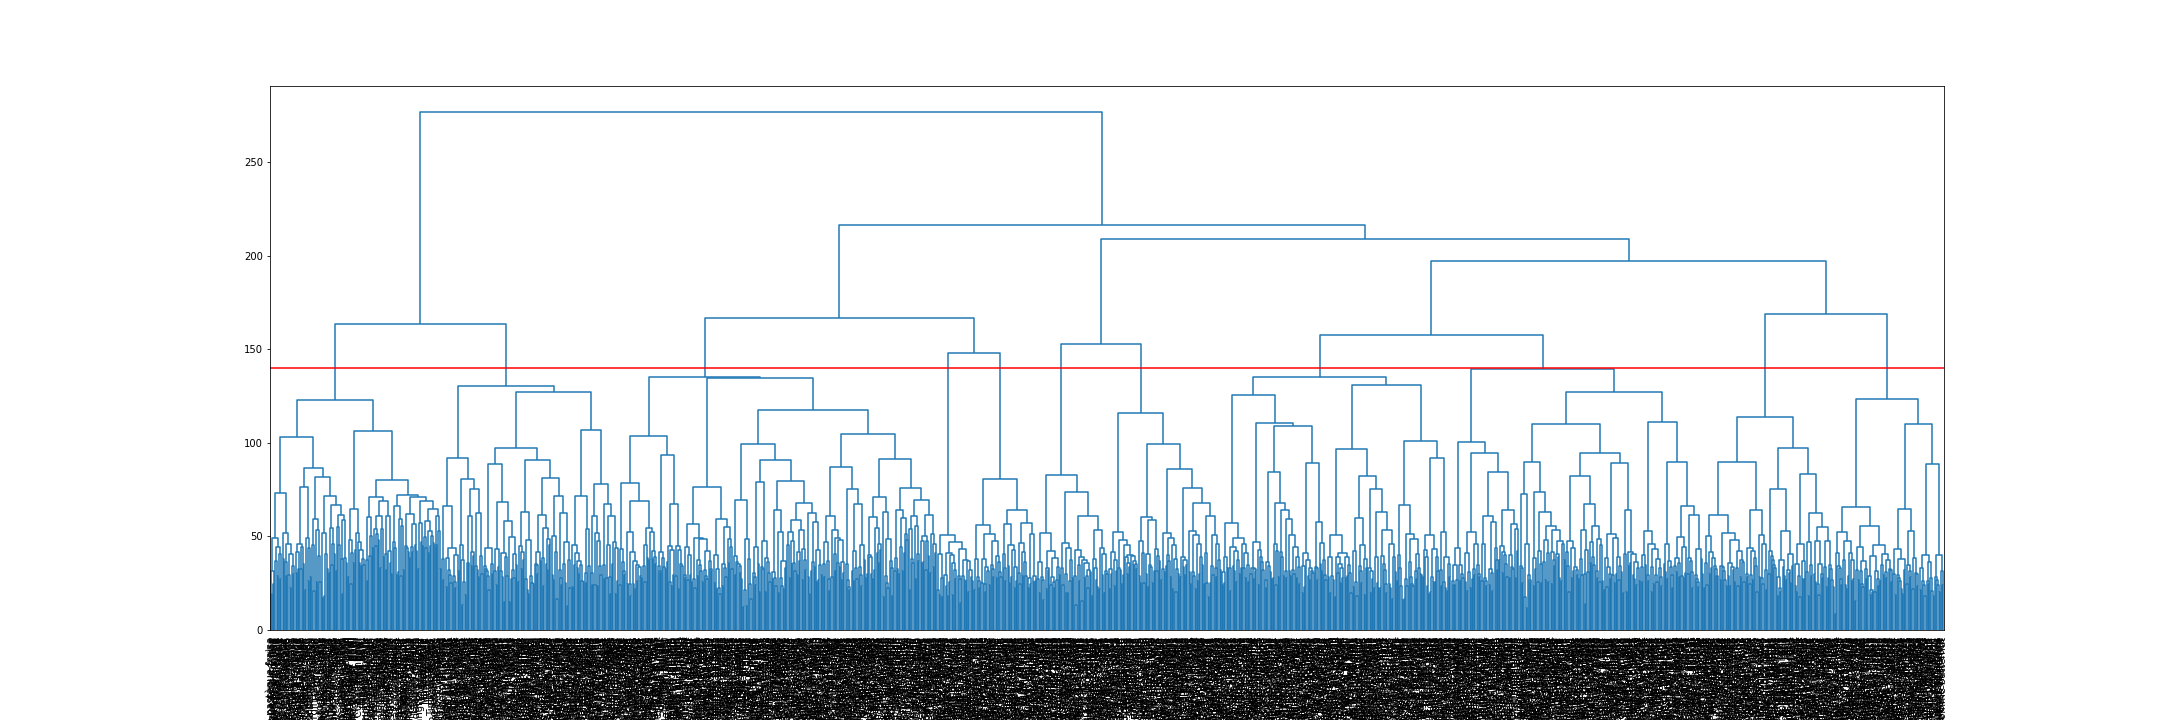

In [ ]:
Z = linkage(jow_title_embeddings_scaled, method = 'ward', metric = 'euclidean')

plt.figure(figsize = (30, 10))
dendrogram(Z, labels = np.array(jow_title_recipes), leaf_rotation = 90, leaf_font_size = 10, color_threshold = 0)
plt.axhline(y = 140, color='r', linestyle='-') # red horizontal line
plt.show()

We have 11 clusters at the red line. But not clear if each cluster makes sense (hard to zoom in and read the labels, they are truncated, should be fixed).

## PCA Analysis

In [ ]:
from sklearn.decomposition import PCA

Number of initial features =  1024
Number of selected features =  153


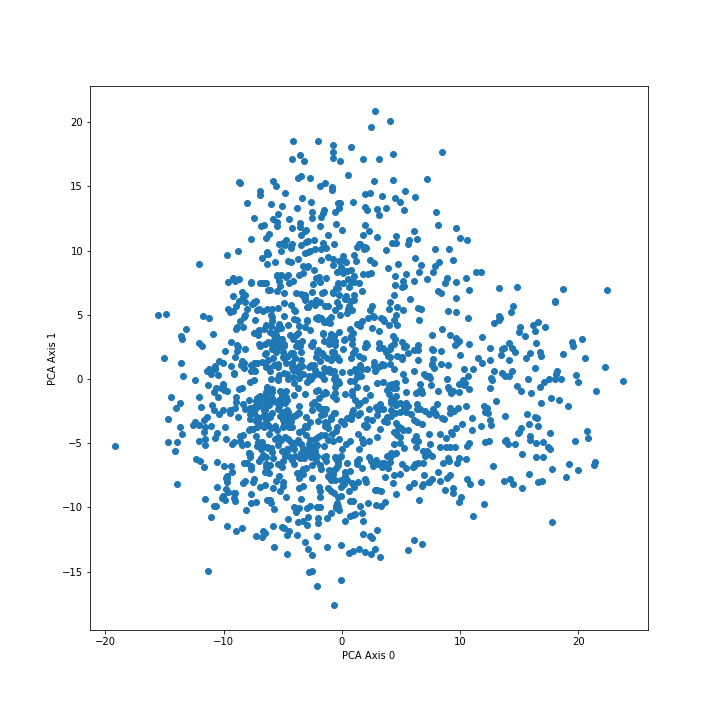

In [ ]:
pca = PCA(n_components = 0.9)   # keep 90% of the variance
jow_title_pca = pca.fit_transform(jow_title_embeddings_scaled)

print("Number of initial features = ", jow_title_embeddings_scaled.shape[1])
print("Number of selected features = ", pca.n_components_)

plt.figure(figsize = (10, 10))
scatter = plt.scatter(jow_title_pca[:, 0], jow_title_pca[:, 1], marker = 'o')
plt.xlabel("PCA Axis 0")
plt.ylabel("PCA Axis 1");

We don't see any clusters. Try to find the optimal number of PCA dimensions with another method :

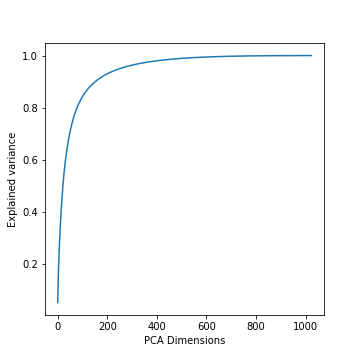

In [ ]:
pca = PCA()
pca.fit(jow_title_embeddings_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize = (5, 5))
plt.plot(cumsum)
plt.xlabel('PCA Dimensions')
plt.ylabel('Explained variance');

The elbow position (around x=150) gives us (approximately) the right number of PCA dimensions. This is compatible with the previous choice keeping 90% of the variance. But there are no obvious clusters showing up ... let's try in 3D

In [ ]:
import plotly.express as px

In [ ]:
pca = PCA(n_components = 0.9)   # keep 90% of the variance
jow_title_pca = pca.fit_transform(jow_title_embeddings_scaled)

print("Number of initial features = ", jow_title_embeddings_scaled.shape[1])
print("Number of selected features = ", pca.n_components_)

dict_pca = {'pca_ax1': jow_title_pca[:,0], 
            'pca_ax2': jow_title_pca[:,1], 
            'pca_ax3': jow_title_pca[:,2], 
            'title': jow_title_recipes}

df_pca = pd.DataFrame.from_dict(dict_pca)
#df_pca.head()

fig = px.scatter_3d(df_pca, x = 'pca_ax1', y = 'pca_ax2', z = 'pca_ax3', hover_name = 'title')
fig.show()

Number of initial features =  1024
Number of selected features =  153


Not better in 3D. Replot in 2D with plotly.express since recipe titles are shown easily



In [ ]:
fig = px.scatter(df_pca, x = 'pca_ax1', y = 'pca_ax2', hover_name = 'title', width = 800, height = 800)
fig.show()

There is no obvious link between recipes that are close to each other. Let's give up this try with PCA.

## t-SNE analysis

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components = 2, method='barnes_hut', random_state = 123)
data_tsne = tsne.fit_transform(jow_title_embeddings_scaled)

dict_tsne = {'tsne_ax1': data_tsne[:,0], 
            'tsne_ax2': data_tsne[:,1], 
            'title': jow_title_recipes}

df_tsne = pd.DataFrame.from_dict(dict_tsne)

fig = px.scatter(df_tsne, x = 'tsne_ax1', y = 'tsne_ax2', hover_name = 'title', width = 800, height = 800)
fig.show()


This is better. There are clusters for 'galettes', 'burgers', 'houmous', 'recipes with chocolate', 'recipes starting with the ingredient Aubergine', etc 

Add a preliminary PCA step

In [ ]:
pca = PCA(n_components = 0.9)   # keep 90% of the variance
jow_title_pca = pca.fit_transform(jow_title_embeddings_scaled)

tsne = TSNE(n_components = 2, method='barnes_hut', random_state = 123)
data_tsne = tsne.fit_transform(jow_title_pca)

dict_tsne = {'tsne_ax1': data_tsne[:,0], 
            'tsne_ax2': data_tsne[:,1], 
            'title': jow_title_recipes}

df_tsne = pd.DataFrame.from_dict(dict_tsne)

fig = px.scatter(df_tsne, x = 'tsne_ax1', y = 'tsne_ax2', hover_name = 'title', width = 800, height = 800)
fig.show()

Same in 3D

In [ ]:
tsne = TSNE(n_components = 3, method='barnes_hut', random_state = 123)
data_tsne = tsne.fit_transform(jow_title_embeddings_scaled)

dict_tsne_3D = {'tsne_ax1': data_tsne[:,0], 
            'tsne_ax2': data_tsne[:,1], 
            'tsne_ax3': data_tsne[:,2],
            'title': jow_title_recipes}

df_tsne_3D = pd.DataFrame.from_dict(dict_tsne_3D)

# This is really hard to see something with the 3D plot
#fig = px.scatter_3d(df_tsne_3D, x = 'tsne_ax1', y = 'tsne_ax2', z = 'tsne_ax3', hover_name = 'title', width = 800, height = 800)
#fig.show()

fig = px.scatter(df_tsne_3D, 
                 x = 'tsne_ax1', 
                 y = 'tsne_ax2', 
                 color = 'tsne_ax3',  
                 hover_name = 'title', 
                 width = 800, 
                 height = 800)
fig.show()

 But what can we do with this? The TSNE algorithm doesn't learn a transformation function, ie there is no `transform` method to be used on menu recipes.  


### Visualize the results of KMeans on JOW with t-SNE

In [ ]:
# PCA
pca = PCA(n_components = 0.95)   # keep 95% of the variance
jow_title_pca = pca.fit_transform(jow_title_embeddings_scaled)

print("Number of initial features = ", jow_title_embeddings_scaled.shape[1])
print("Number of PCA selected features = ", pca.n_components_)

# TSNE
tsne = TSNE(n_components = 2, method='barnes_hut', random_state = 123)
jow_tsne = tsne.fit_transform(jow_title_pca)

# Store in a dataframe
dict_tsne = {'tsne_ax1': jow_tsne[:,0], 
            'tsne_ax2': jow_tsne[:,1], 
            'title': jow_title_recipes,
            'cluster_number': df_res_kmeans_k10['cluster_number'].astype(str).values,    # useful to get discrete colors below
            'cluster_meaning': df_res_kmeans_k10['cluster_meaning'].values}

df_tsne = pd.DataFrame.from_dict(dict_tsne)

# Plot
fig = px.scatter(df_tsne, 
                 x = 'tsne_ax1', 
                 y = 'tsne_ax2', 
                 color = 'cluster_number',
                 hover_name = 'title', 
                 hover_data = ['cluster_number', 'cluster_meaning'], 
                 width = 800, 
                 height = 800)
fig.show()

Number of initial features =  1024
Number of PCA selected features =  252


This does not help

## Test whether NLP prediction task on menu recipes works better if clustering is done beforehand

### First do standard NLP to have benchmarking results


For each menu recipe, we want to select with NLP all recipes in JOW whose similary score s is larger than max_score - radius (for each menu recipe, max_score is the similarity score of the JOW recipe that is the closest to the menu recipe).

In [ ]:
# Function that returns the hits in data_base corresponding to the query,
# whose similarity scores are among the top_k biggest scores and larger than max_score - radius
def most_similar_recipes(query, database_embedding, model, top_k = 20, radius = 0.1):
    query_embedding = model.encode(query, convert_to_tensor=True)
    hits = util.semantic_search(query_embedding, database_embedding, top_k = top_k)    #find the top_k closest database recipes from query
    hits = hits[0]      #Get the hits for the first query (here only one query is given)

    # Keep only the recipes whose similarity scores are highest that max_score - radius
    best_hits = []
    for k, hit in enumerate(hits):
        max_score = hits[0]['score']  # hits is stored by descending scores
        if hit['score'] > max_score - radius:
            best_hits.append(hit)

    return best_hits
    
# Quick and dirty
# Function that finds for each recipe in the Series menu_data[menu_label_col] the closest matching recipes in the recipe database
# embedded in 'database_embedding' with the NLP model 'model'
# The function returns a dataframe with the results
def find_and_store_most_similar_recipes(menu_data, menu_label_col, database_embedding, model, top_k = 20, radius = 0.1):
    dict_res = {}

    for index, row in menu_data.iterrows():    # loop on rows of menu_data
        query = row[menu_label_col]
        
        best_hits = most_similar_recipes(query, database_embedding, model, top_k = top_k, radius = radius)
        
        # Store results in a dictionary
        for k, hit in enumerate(best_hits):
            jow_fullname_recipe = jow_fullname_recipes[hit['corpus_id']]
            jow_recipe = jow_data[jow_data['name_with_ingredients']==jow_fullname_recipe].index[0]
        
            # See if matching for this query had been found by hand
            closest_jow = row['Closest JOW recipe by hand']    # recipe in french

            # ... store in an index if the recipe guess corresponds to one of the matches found by hand
            if isinstance(closest_jow, list):
                matched_jow_idx = 1 if jow_recipe in closest_jow else 0
            else:
                matched_jow_idx = 1 if jow_recipe==closest_jow else 0


            # For each menu recipe (index) and hit (k), store 
            # menu_recipe_id, menu_recipe_label, jow7t_guess, similarity_rank, similary_score, is_matched_jow, is_matched_7t, is_matched_tot
            dict_res[str(index)+'_'+str(k)] = [query, jow_recipe, k+1, hit['score'], matched_jow_idx]  

    # Convert the dictionary to a dataframe
    data_res = pd.DataFrame.from_dict(dict_res, orient = 'index', \
                                    columns = ['menu_recipe_label', 'jow_guess', 'similarity_rank', \
                                               'similarity_score', 'is_matched_jow'])\
                                    .reset_index(drop = True)

    return data_res



Let's first look at predictions for recipes which could be matched by hand

In [ ]:
menu_data_withmatchjow = menu_data[menu_data['Closest JOW recipe by hand']!='no match']
print("Number of queries = ", menu_data_withmatchjow.shape[0])

Number of queries =  44


In [ ]:
top_k = 5
df_res_step3 = find_and_store_most_similar_recipes(menu_data_withmatchjow, 'Menu all', jow_fullname_embeddings, model, top_k = top_k, radius = 1)

#Add the columns with matchings done by hand
df_res_step3['Closest JOW recipe by hand'] = df_res_step3['menu_recipe_label'].apply(lambda recipe: menu_data[menu_data['Menu all']==recipe]['Closest JOW recipe by hand'].values[0])
df_res_step3['Closest 7t recipe by hand'] = df_res_step3['menu_recipe_label'].apply(lambda recipe: menu_data[menu_data['Menu all']==recipe]['Closest 7t recipe by hand'].values[0])
df_res_step3

,menu_recipe_label,jow_guess,similarity_rank,similarity_score,is_matched_jow,Closest JOW recipe by hand,Closest 7t recipe by hand
0,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",Burger raclette,1,0.726083,1,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
1,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",French Burger,2,0.721682,1,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
2,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",Brunch Burger,3,0.706234,0,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
3,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",Super Bacon Burger,4,0.696295,1,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
4,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",Blue Burger,5,0.684877,1,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
...,...,...,...,...,...,...,...
215,"Plats, Saucisse - Purée truffée, Saucisse d'Auvergne, purée à la truffe, crème d'Abondance",Saucisse purée & épinards,1,0.711127,1,"[Saucisse & purée maison, Saucisse purée & épinards, Pommes de terre & saucisses rôties, Knack & purée]","[sweet potatoes with pecans & sausage, sweet potatoes with pecans and sausage]"
216,"Plats, Saucisse - Purée truffée, Saucisse d'Auvergne, purée à la truffe, crème d'Abondance",Saucisse & purée maison,2,0.687571,1,"[Saucisse & purée maison, Saucisse purée & épinards, Pommes de terre & saucisses rôties, Knack & purée]","[sweet potatoes with pecans & sausage, sweet potatoes with pecans and sausage]"
217,"Plats, Saucisse - Purée truffée, Saucisse d'Auvergne, purée à la truffe, crème d'Abondance",Grilled cheese cochon à la truffe,3,0.680487,0,"[Saucisse & purée maison, Saucisse purée & épinards, Pommes de terre & saucisses rôties, Knack & purée]","[sweet potatoes with pecans & sausage, sweet potatoes with pecans and sausage]"
218,"Plats, Saucisse - Purée truffée, Saucisse d'Auvergne, purée à la truffe, crème d'Abondance",Saucisse aux oignons,4,0.652564,0,"[Saucisse & purée maison, Saucisse purée & épinards, Pommes de terre & saucisses rôties, Knack & purée]","[sweet potatoes with pecans & sausage, sweet potatoes with pecans and sausage]"


In [ ]:
print("Number of good matchings among outputs with rank 1 :")
df_res_step3[(df_res_step3['similarity_rank']==1) & (df_res_step3['is_matched_jow']==1)].shape[0]

Number of good matchings among outputs with rank 1 :


28

In [ ]:
df_tmp = pd.DataFrame(df_res_step3.groupby('menu_recipe_label')['is_matched_jow'].agg(sum))
df_tmp['is_matched_jow'] = df_tmp['is_matched_jow'].apply(lambda x: x if x==0 else 1)

print("Number of good matchings among the cloud of pre-selected recipes :")
df_tmp[df_tmp['is_matched_jow']==1].shape[0]

Number of good matchings among the cloud of pre-selected recipes :


37

Let's have a closer look at menu recipes that have not been successfully matched

In [ ]:
recipes_notmatched2 = df_res_step3[(df_res_step3['is_matched_jow']==0) & (df_res_step3['similarity_rank']==1)]['menu_recipe_label'].values.tolist()
print(len(recipes_notmatched2))

df_res_step3[df_res_step3['menu_recipe_label'].isin(recipes_notmatched2)]

16


,menu_recipe_label,jow_guess,similarity_rank,similarity_score,is_matched_jow,Closest JOW recipe by hand,Closest 7t recipe by hand
40,"Anju, Sewoo kkanpoong (8 pcs), Crevettes frites dans une sauce aigre douce",Poêlée crevettes & légumes express,1,0.621381,0,"[Crevettes teriyaki, Crevettes miel sésame]",no match
41,"Anju, Sewoo kkanpoong (8 pcs), Crevettes frites dans une sauce aigre douce",Nouilles sautées aux crevettes,2,0.600914,0,"[Crevettes teriyaki, Crevettes miel sésame]",no match
42,"Anju, Sewoo kkanpoong (8 pcs), Crevettes frites dans une sauce aigre douce",Pad Thaï crevette,3,0.594309,0,"[Crevettes teriyaki, Crevettes miel sésame]",no match
43,"Anju, Sewoo kkanpoong (8 pcs), Crevettes frites dans une sauce aigre douce",Nouilles de riz & porc sauté,4,0.571034,0,"[Crevettes teriyaki, Crevettes miel sésame]",no match
44,"Anju, Sewoo kkanpoong (8 pcs), Crevettes frites dans une sauce aigre douce",Riz sauté aux crevettes,5,0.565556,0,"[Crevettes teriyaki, Crevettes miel sésame]",no match
...,...,...,...,...,...,...,...
205,"Les plats, Canard, purée de cresson, pommes boulangères, trompettes de la mort & jus de volaille à l'argousier",Parmentier de canard aux patates douces,1,0.675605,0,"[Parmentier de canard, Magret de canard & purée]",no match
206,"Les plats, Canard, purée de cresson, pommes boulangères, trompettes de la mort & jus de volaille à l'argousier",Parmentier de canard,2,0.635657,1,"[Parmentier de canard, Magret de canard & purée]",no match
207,"Les plats, Canard, purée de cresson, pommes boulangères, trompettes de la mort & jus de volaille à l'argousier",Magret de canard & purée,3,0.634149,1,"[Parmentier de canard, Magret de canard & purée]",no match
208,"Les plats, Canard, purée de cresson, pommes boulangères, trompettes de la mort & jus de volaille à l'argousier",Magret de canard à l'orange,4,0.633614,0,"[Parmentier de canard, Magret de canard & purée]",no match


Let's have a look at predictions for recipes which could not be matched by hand

In [ ]:
menu_data_nomatchjow = menu_data[menu_data['Closest JOW recipe by hand']=='no match']
print("Number of queries = ", menu_data_nomatchjow.shape[0])

Number of queries =  16


In [ ]:
#top_k = jow7t_fullname_embeddings.shape[0]       # Number of JOW recipes
#df_res_step4 = find_and_store_most_similar_recipes(menu_data_nomatchjow, 'Menu all', jow_fullname_embeddings, model, top_k = top_k, radius = 0.05)
top_k = 5
df_res_step4 = find_and_store_most_similar_recipes(menu_data_nomatchjow, 'Menu all', jow_fullname_embeddings, model, top_k = top_k, radius = 1)

#Add the columns with matchings done by hand
df_res_step4['Closest JOW recipe by hand'] = df_res_step4['menu_recipe_label'].apply(lambda recipe: menu_data[menu_data['Menu all']==recipe]['Closest JOW recipe by hand'].values[0])
df_res_step4['Closest 7t recipe by hand'] = df_res_step4['menu_recipe_label'].apply(lambda recipe: menu_data[menu_data['Menu all']==recipe]['Closest 7t recipe by hand'].values[0])
df_res_step4

,menu_recipe_label,jow_guess,similarity_rank,similarity_score,is_matched_jow,Closest JOW recipe by hand,Closest 7t recipe by hand
0,"Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",Italian burger,1,0.741322,0,no match,"[awesome turkey burgers, blue cheese stuffed turkey burgers, chicken & broccoli burgers, greek burgers, spinach feta turkey burgers]"
1,"Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",Cheeseburger veggie,2,0.718946,0,no match,"[awesome turkey burgers, blue cheese stuffed turkey burgers, chicken & broccoli burgers, greek burgers, spinach feta turkey burgers]"
2,"Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",Tom burger,3,0.714138,0,no match,"[awesome turkey burgers, blue cheese stuffed turkey burgers, chicken & broccoli burgers, greek burgers, spinach feta turkey burgers]"
3,"Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",Classic Cheeseburger,4,0.707396,0,no match,"[awesome turkey burgers, blue cheese stuffed turkey burgers, chicken & broccoli burgers, greek burgers, spinach feta turkey burgers]"
4,"Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",French Burger,5,0.700665,0,no match,"[awesome turkey burgers, blue cheese stuffed turkey burgers, chicken & broccoli burgers, greek burgers, spinach feta turkey burgers]"
...,...,...,...,...,...,...,...
75,"Plats, Hot-Duck, Pain brioché, confit de canard, ketchup de pomme, coleslaw, Tomme des Aravis, frites",Tom burger,1,0.692306,0,no match,no match
76,"Plats, Hot-Duck, Pain brioché, confit de canard, ketchup de pomme, coleslaw, Tomme des Aravis, frites",French Burger,2,0.689379,0,no match,no match
77,"Plats, Hot-Duck, Pain brioché, confit de canard, ketchup de pomme, coleslaw, Tomme des Aravis, frites",Blue Burger,3,0.686737,0,no match,no match
78,"Plats, Hot-Duck, Pain brioché, confit de canard, ketchup de pomme, coleslaw, Tomme des Aravis, frites",Grilled cheese poulet & confit d'oignon,4,0.662828,0,no match,no match


### Repeat by adding the Kmeans clustering step beforehand

In [ ]:
t0 = time.time()
jow_title_recipes = list(jow_data['recipe_name'].values)
jow_title_embeddings = model.encode(jow_title_recipes, convert_to_tensor=False)
print("Time lapse for JOW embedding (s) = ", time.time()-t0)

t0 = time.time()
jow_fullname_recipes = list(jow_data['name_with_ingredients'].values)
jow_fullname_embeddings = model.encode(jow_fullname_recipes, convert_to_tensor=True)
print("Time lapse for JOW embedding (s) = ", time.time()-t0)

Time lapse for JOW embedding (s) =  3.9450130462646484
Time lapse for JOW embedding (s) =  10.223949193954468


In [ ]:
scaler1 = StandardScaler()
#scaler2 = StandardScaler()
jow_title_embeddings_scaled = scaler1.fit_transform(jow_title_embeddings)
#jow_fullname_embeddings_scaled = scaler2.fit_transform(jow_fullname_embeddings)

In [ ]:
k = 10     # Choose the number of clusters
kmeans10 = KMeans(n_clusters = k, n_init = 10, random_state = 123)                # define the model
kmeans10.fit(jow_title_embeddings_scaled)        # compute the clusters    

dict_res_kmeans = {}
dict_res_kmeans['recipe_name'] = list(jow_data['recipe_name'].values)
dict_res_kmeans['cluster_number'] = kmeans10.labels_

df_res_kmeans_k10 = pd.DataFrame.from_dict(dict_res_kmeans)

In [ ]:
def find_and_store_most_similar_recipes_after_kmeans(menu_data, database_embedding, model, scaler, clustering_method, top_k = 20, radius = 0.1):
    dict_res = {}

    for index, row in menu_data.iterrows():    # loop on rows of menu_data
        query = row['Menu all']
        query_embedding = model.encode(query, convert_to_tensor=True)
        
        query2 = row['Menu Title and Subtitle']
        query2_embedding = model.encode(query2, convert_to_tensor=False)
        query2_embedding = query2_embedding.reshape(1, -1)
        query2_embedding_scaled = scaler.transform(query2_embedding)
        # Find the cluster of the menu recipe 
        query_cluster = clustering_method.predict(query2_embedding_scaled)  
            
        # Find the JOW recipes in this cluster
        jow_in_cluster = df_res_kmeans_k10[df_res_kmeans_k10['cluster_number']==query_cluster[0]]['recipe_name'].values
        
        # Get their indices
        jow_in_cluster_idx = [jow_data.index.get_loc(recipe_name) for recipe_name in jow_in_cluster]

        # Get the corresponding embedding vectors
        jow_in_cluster_emb = database_embedding[jow_in_cluster_idx]
        # Find the closest recipes from query in the JOW cluster
        hits = util.semantic_search(query_embedding, jow_in_cluster_emb, top_k = top_k)    #find the top_k closest database recipes from query
        hits = hits[0]      #Get the hits for the first query (here only one query is given)

        # Keep only the recipes whose similarity scores are highest that max_score - radius
        best_hits = []
        for k, hit in enumerate(hits):
            max_score = hits[0]['score']  # hits is stored by descending scores
            if hit['score'] > max_score - radius:
                best_hits.append(hit)
        
        # Store results in a dictionary
        for k, hit in enumerate(best_hits):
            jow_fullname_recipe = jow_fullname_recipes[jow_in_cluster_idx[hit['corpus_id']]]

            jow_recipe = jow_data[jow_data['name_with_ingredients']==jow_fullname_recipe].index[0]
        
            # See if matching for this query had been found by hand
            closest_jow = row['Closest JOW recipe by hand']    # recipe in french

            # ... store in an index if the recipe guess corresponds to one of the matches found by hand
            if isinstance(closest_jow, list):
                matched_jow_idx = 1 if jow_recipe in closest_jow else 0
            else:
                matched_jow_idx = 1 if jow_recipe==closest_jow else 0


            # For each menu recipe (index) and hit (k), store 
            # menu_recipe_id, menu_recipe_label, jow7t_guess, similarity_rank, similary_score, is_matched_jow, is_matched_7t, is_matched_tot
            dict_res[str(index)+'_'+str(k)] = [query, jow_recipe, k+1, hit['score'], matched_jow_idx]  

    # Convert the dictionary to a dataframe
    data_res = pd.DataFrame.from_dict(dict_res, orient = 'index', \
                                    columns = ['menu_recipe_label', 'jow_guess', 'similarity_rank', \
                                               'similarity_score', 'is_matched_jow'])\
                                    .reset_index(drop = True)

    return data_res

Let's first look at predictions for recipes which could be matched by hand

In [ ]:
menu_data_withmatchjow = menu_data[menu_data['Closest JOW recipe by hand']!='no match']
print("Number of queries = ", menu_data_withmatchjow.shape[0])

Number of queries =  44


In [ ]:
top_k = 5
df_res_step1 = find_and_store_most_similar_recipes_after_kmeans(menu_data_withmatchjow, jow_fullname_embeddings, model, scaler1, kmeans10,  top_k = top_k, radius = 1)

#Add the columns with matchings done by hand
df_res_step1['Closest JOW recipe by hand'] = df_res_step1['menu_recipe_label'].apply(lambda recipe: menu_data[menu_data['Menu all']==recipe]['Closest JOW recipe by hand'].values[0])
df_res_step1['Closest 7t recipe by hand'] = df_res_step1['menu_recipe_label'].apply(lambda recipe: menu_data[menu_data['Menu all']==recipe]['Closest 7t recipe by hand'].values[0])
df_res_step1

,menu_recipe_label,jow_guess,similarity_rank,similarity_score,is_matched_jow,Closest JOW recipe by hand,Closest 7t recipe by hand
0,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",Burger raclette,1,0.726083,1,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
1,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",French Burger,2,0.721682,1,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
2,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",Brunch Burger,3,0.706234,0,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
3,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",Super Bacon Burger,4,0.696295,1,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
4,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",Blue Burger,5,0.684877,1,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
...,...,...,...,...,...,...,...
215,"Plats, Saucisse - Purée truffée, Saucisse d'Auvergne, purée à la truffe, crème d'Abondance",Saucisse purée & épinards,1,0.711127,1,"[Saucisse & purée maison, Saucisse purée & épinards, Pommes de terre & saucisses rôties, Knack & purée]","[sweet potatoes with pecans & sausage, sweet potatoes with pecans and sausage]"
216,"Plats, Saucisse - Purée truffée, Saucisse d'Auvergne, purée à la truffe, crème d'Abondance",Saucisse & purée maison,2,0.687571,1,"[Saucisse & purée maison, Saucisse purée & épinards, Pommes de terre & saucisses rôties, Knack & purée]","[sweet potatoes with pecans & sausage, sweet potatoes with pecans and sausage]"
217,"Plats, Saucisse - Purée truffée, Saucisse d'Auvergne, purée à la truffe, crème d'Abondance",Grilled cheese cochon à la truffe,3,0.680487,0,"[Saucisse & purée maison, Saucisse purée & épinards, Pommes de terre & saucisses rôties, Knack & purée]","[sweet potatoes with pecans & sausage, sweet potatoes with pecans and sausage]"
218,"Plats, Saucisse - Purée truffée, Saucisse d'Auvergne, purée à la truffe, crème d'Abondance",Saucisse aux oignons,4,0.652563,0,"[Saucisse & purée maison, Saucisse purée & épinards, Pommes de terre & saucisses rôties, Knack & purée]","[sweet potatoes with pecans & sausage, sweet potatoes with pecans and sausage]"


In [ ]:
print("Number of good matchings among outputs with rank 1 :")
df_res_step1[(df_res_step1['similarity_rank']==1) & (df_res_step1['is_matched_jow']==1)].shape[0]

Number of good matchings among outputs with rank 1 :


23

In [ ]:
df_res_step1 = df_res_step1.rename({'jow_guess' : 'jow_guess_with_kmeans'}, axis =1)
df_res_step3 = df_res_step3.rename({'jow_guess' : 'jow_guess_no_kmeans'}, axis = 1)
df_res_step13 = df_res_step1[df_res_step1['similarity_rank']==1].merge(df_res_step3[df_res_step3['similarity_rank']==1], on = 'menu_recipe_label')
df_res_step13

,menu_recipe_label,jow_guess_with_kmeans,similarity_rank_x,similarity_score_x,is_matched_jow_x,Closest JOW recipe by hand_x,Closest 7t recipe by hand_x,jow_guess_no_kmeans,similarity_rank_y,similarity_score_y,is_matched_jow_y,Closest JOW recipe by hand_y,Closest 7t recipe by hand_y
0,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",Burger raclette,1,0.726083,1,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match,Burger raclette,1,0.726083,1,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
1,"Burgers, Bon & Beau, Bœuf (VBF Metzger), Cheddar, Sucrine, Bacon, Tomate Confite, Sauce poivre maison",Super Bacon Burger,1,0.789362,1,"[Super Bacon Burger, Summer burger]",no match,Super Bacon Burger,1,0.789361,1,"[Super Bacon Burger, Summer burger]",no match
2,"Poke Bowls, Black bowl, Thon, Riz noir, Avocat, Oignon rouge, Cébette, Concombre, Sésame, Coriandre, Grenade, Sauce douce",Primavera Poke bowl,1,0.832397,1,"[Tuna bowl, Primavera Poke bowl]",no match,Primavera Poke bowl,1,0.832397,1,"[Tuna bowl, Primavera Poke bowl]",no match
3,"Salades, Crispy Caesar, Croquettes de poulet, Parmesan, Champignons bruns, Salade Romaine, Ciboulette",Salade César,1,0.750794,1,"[Salade César, Salade au poulet pané]","[better-for-you grilled chicken caesar salad, favorite grilled chicken caesar salad, grilled chicken a la caesar, grilled chicken caesar salad]",Salade César,1,0.750794,1,"[Salade César, Salade au poulet pané]","[better-for-you grilled chicken caesar salad, favorite grilled chicken caesar salad, grilled chicken a la caesar, grilled chicken caesar salad]"
4,"Desserts, Cheesecake maison",Cheesecake,1,0.618707,1,Cheesecake,no match,Cheesecake,1,0.618707,1,Cheesecake,no match
5,"Desserts, Mousse au chocolat maison",Mousse au chocolat maison,1,0.817192,1,Mousse au chocolat maison,"[chocolate mousse, chocolate dream mousse, raw chocolate mousse, lactose free]",Mousse au chocolat maison,1,0.817192,1,Mousse au chocolat maison,"[chocolate mousse, chocolate dream mousse, raw chocolate mousse, lactose free]"
6,"Desserts, Fondant au chocolat artisan boulanger",Fondant au chocolat,1,0.775830,1,Fondant au chocolat,no match,Fondant au chocolat,1,0.775830,1,Fondant au chocolat,no match
7,"Desserts, Financier artisan boulanger",Financier à la framboise,1,0.572464,1,"[Financier cerises noires & pistache, Financier à la framboise]",no match,Financier à la framboise,1,0.572464,1,"[Financier cerises noires & pistache, Financier à la framboise]",no match
8,"Anju, Sewoo kkanpoong (8 pcs), Crevettes frites dans une sauce aigre douce",Bo bun aux nems,1,0.521456,0,"[Crevettes teriyaki, Crevettes miel sésame]",no match,Poêlée crevettes & légumes express,1,0.621381,0,"[Crevettes teriyaki, Crevettes miel sésame]",no match
9,"Classiques, Bulgogi, Bœuf émincé à la sauce soja, légumes, riz",Tuna bowl,1,0.560036,0,"[Wok de bœuf légumes croquants, Bœuf thaï, Bœuf sauté au chou, Aiguillettes de bœuf & légumes poêlés]",beef bulgogi(korean marinated beef),Wok de légumes & aiguillettes végétales,1,0.737402,0,"[Wok de bœuf légumes croquants, Bœuf thaï, Bœuf sauté au chou, Aiguillettes de bœuf & légumes poêlés]",beef bulgogi(korean marinated beef)


Results are worse when KMeans is used.

### Repeat by replacing KMeans with CAH

In [ ]:
t0 = time.time()
jow_title_recipes = list(jow_data['recipe_name'].values)
jow_title_embeddings = model.encode(jow_title_recipes, convert_to_tensor=False)
print("Time lapse for JOW embedding (s) = ", time.time()-t0)

t0 = time.time()
jow_fullname_recipes = list(jow_data['name_with_ingredients'].values)
jow_fullname_embeddings = model.encode(jow_fullname_recipes, convert_to_tensor=True)
print("Time lapse for JOW embedding (s) = ", time.time()-t0)

Time lapse for JOW embedding (s) =  4.776864051818848
Time lapse for JOW embedding (s) =  11.0951669216156


In [ ]:
scaler1 = StandardScaler()
#scaler2 = StandardScaler()
jow_title_embeddings_scaled = scaler1.fit_transform(jow_title_embeddings)
#jow_fullname_embeddings_scaled = scaler2.fit_transform(jow_fullname_embeddings)

In [ ]:
k = 11     # Choose the number of clusters
cah11 = AgglomerativeClustering(n_clusters = k)                # define the model
cah11.fit(jow_title_embeddings_scaled)        # compute the clusters    

dict_res_cah = {}
dict_res_cah['recipe_name'] = list(jow_data['recipe_name'].values)
dict_res_cah['cluster_number'] = cah11.labels_

df_res_cah_k11 = pd.DataFrame.from_dict(dict_res_cah)

In [ ]:
# The way it is written is really AWFUL but I had to do it very quickly with copy-paste
def find_and_store_most_similar_recipes_after_cah(menu_data, database_embedding, model, scaler, clustering_method, top_k = 20, radius = 0.1):
    dict_res = {}

    for index, row in menu_data.iterrows():    # loop on rows of menu_data
        query = row['Menu all']
        query_embedding = model.encode(query, convert_to_tensor=True)
        
        query2 = row['Menu Title and Subtitle']
        query2_embedding = model.encode(query2, convert_to_tensor=False)
        query2_embedding = query2_embedding.reshape(1, -1)
        query2_embedding_scaled = scaler.transform(query2_embedding)
        # Find the cluster of the menu recipe 
        query_cluster = clustering_method.predict(query2_embedding_scaled)  
            
        # Find the JOW recipes in this cluster
        jow_in_cluster = df_res_cah_k11[df_res_cah_k11['cluster_number']==query_cluster[0]]['recipe_name'].values
        
        # Get their indices
        jow_in_cluster_idx = [jow_data.index.get_loc(recipe_name) for recipe_name in jow_in_cluster]

        # Get the corresponding embedding vectors
        jow_in_cluster_emb = database_embedding[jow_in_cluster_idx]
        # Find the closest recipes from query in the JOW cluster
        hits = util.semantic_search(query_embedding, jow_in_cluster_emb, top_k = top_k)    #find the top_k closest database recipes from query
        hits = hits[0]      #Get the hits for the first query (here only one query is given)

        # Keep only the recipes whose similarity scores are highest that max_score - radius
        best_hits = []
        for k, hit in enumerate(hits):
            max_score = hits[0]['score']  # hits is stored by descending scores
            if hit['score'] > max_score - radius:
                best_hits.append(hit)
        
        # Store results in a dictionary
        for k, hit in enumerate(best_hits):
            jow_fullname_recipe = jow_fullname_recipes[jow_in_cluster_idx[hit['corpus_id']]]

            jow_recipe = jow_data[jow_data['name_with_ingredients']==jow_fullname_recipe].index[0]
        
            # See if matching for this query had been found by hand
            closest_jow = row['Closest JOW recipe by hand']    # recipe in french

            # ... store in an index if the recipe guess corresponds to one of the matches found by hand
            if isinstance(closest_jow, list):
                matched_jow_idx = 1 if jow_recipe in closest_jow else 0
            else:
                matched_jow_idx = 1 if jow_recipe==closest_jow else 0


            # For each menu recipe (index) and hit (k), store 
            # menu_recipe_id, menu_recipe_label, jow7t_guess, similarity_rank, similary_score, is_matched_jow, is_matched_7t, is_matched_tot
            dict_res[str(index)+'_'+str(k)] = [query, jow_recipe, k+1, hit['score'], matched_jow_idx]  

    # Convert the dictionary to a dataframe
    data_res = pd.DataFrame.from_dict(dict_res, orient = 'index', \
                                    columns = ['menu_recipe_label', 'jow_guess', 'similarity_rank', \
                                               'similarity_score', 'is_matched_jow'])\
                                    .reset_index(drop = True)

    return data_res

Let's first look at predictions for recipes which could be matched by hand

In [ ]:
menu_data_withmatchjow = menu_data[menu_data['Closest JOW recipe by hand']!='no match']
print("Number of queries = ", menu_data_withmatchjow.shape[0])

Number of queries =  44


In [ ]:
top_k = 5
df_res_step1 = find_and_store_most_similar_recipes_after_cah(menu_data_withmatchjow, jow_fullname_embeddings, model, scaler1, cah11,  top_k = top_k, radius = 1)

#Add the columns with matchings done by hand
df_res_step1['Closest JOW recipe by hand'] = df_res_step1['menu_recipe_label'].apply(lambda recipe: menu_data[menu_data['Menu all']==recipe]['Closest JOW recipe by hand'].values[0])
df_res_step1['Closest 7t recipe by hand'] = df_res_step1['menu_recipe_label'].apply(lambda recipe: menu_data[menu_data['Menu all']==recipe]['Closest 7t recipe by hand'].values[0])
df_res_step1

AttributeError: ignored

Damn! Stupid! There is no `predict` method for AgglomerativeClustering! Use a classifier (see page 257, Geron's book).
And then try also with DBScan.